In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

Files Paths and Loading 

True


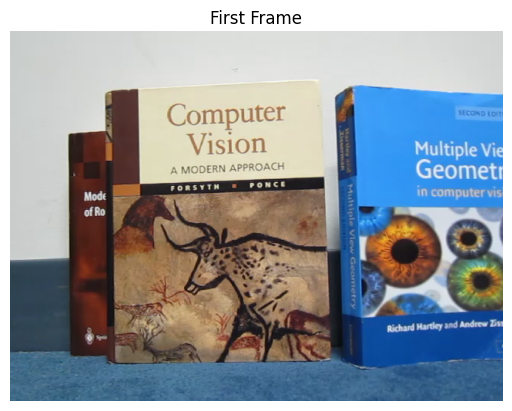

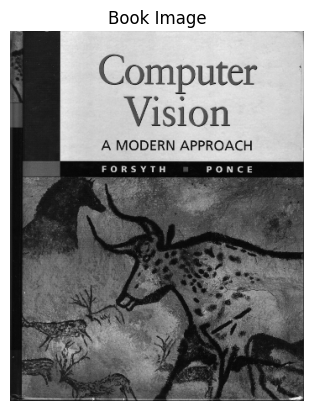

In [3]:
book_image_path = r"D:\MERNA\CV_assignments\assignment_2_materials\cv_cover.jpg"
book_vid_path = r"D:\MERNA\CV_assignments\assignment_2_materials\book.mov"
movie_video = r"D:\MERNA\CV_assignments\assignment_2_materials\ar_source.mov"
cropped_video = r"D:\MERNA\CV_assignments\cropped_video.mp4"
output_video = r"D:\MERNA\CV_assignments\output_video.mp4"

book_img = cv2.imread(book_image_path, cv2.IMREAD_GRAYSCALE)

book_video = cv2.VideoCapture(book_vid_path)

# Check if the video is opened successfully
if not book_video.isOpened() or not book_img.any():
    print("Error: Cannot open video file or book image.")
else :
    # extract the first frame from the video
    flag, firstframe = book_video.read()
    print(flag)
    firstframe = cv2.cvtColor(firstframe, cv2.COLOR_BGR2RGB)
    # Convert the first frame to grayscale       
    gray_firstframe = cv2.cvtColor(firstframe, cv2.COLOR_BGR2GRAY)
    
    plt.imshow(firstframe)
    plt.axis('off')  # Turn off axis labels
    plt.title("First Frame")
    plt.show()
    plt.imshow(book_img, cmap='gray')
    plt.title("Book Image")
    plt.axis('off')
    plt.show()
    



# Detect keypoints and descriptors using SIFT

Each match object is an instance of cv2.DMatch containing m.queryIdx ,m.trainIdx ,m.distance


Number of good matches: 493
Good matches after sorting: [< cv2.DMatch 0000020B980C99F0>, < cv2.DMatch 0000020B980CAD30>, < cv2.DMatch 0000020B980DA5B0>, < cv2.DMatch 0000020B980DA5F0>, < cv2.DMatch 0000020B980CAD70>, < cv2.DMatch 0000020B980CE1F0>, < cv2.DMatch 0000020B980D6C30>, < cv2.DMatch 0000020B980DA1F0>, < cv2.DMatch 0000020B980DE1F0>, < cv2.DMatch 0000020B980D6BF0>, < cv2.DMatch 0000020B980D6370>, < cv2.DMatch 0000020B980D4F70>, < cv2.DMatch 0000020B980D65F0>, < cv2.DMatch 0000020B980D6330>, < cv2.DMatch 0000020B980D6570>, < cv2.DMatch 0000020B980CC530>, < cv2.DMatch 0000020B980C8670>, < cv2.DMatch 0000020B980C8970>, < cv2.DMatch 0000020B980D4FB0>, < cv2.DMatch 0000020B980CB5F0>, < cv2.DMatch 0000020B980D01B0>, < cv2.DMatch 0000020B980CAB30>, < cv2.DMatch 0000020B980CB1B0>, < cv2.DMatch 0000020B980DCA30>, < cv2.DMatch 0000020B980D0130>, < cv2.DMatch 0000020B980D49B0>, < cv2.DMatch 0000020B980CC030>, < cv2.DMatch 0000020B980D2570>, < cv2.DMatch 0000020B980CA7F0>, < cv2.DMatch 00

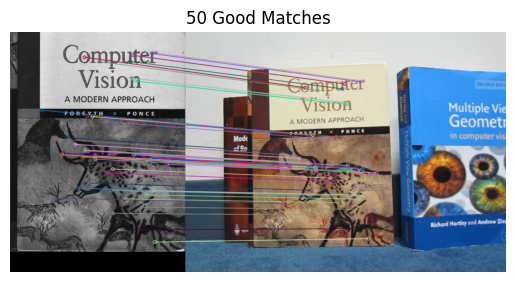

In [4]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(book_img, None)
kp2, des2 = sift.detectAndCompute(gray_firstframe, None)

# Match descriptors with BFMatcher and KNN
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)
# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
print(f"Number of good matches: {len(good_matches)}")    
# PICK 50 random matches
good_matches = sorted(good_matches,key=lambda x: x.distance)[:50]  
print(f"Good matches after sorting: {good_matches}")
# Draw the matches  
img_matches = cv2.drawMatches(book_img, kp1, firstframe, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_matches)
plt.axis('off')           
plt.title("50 Good Matches")
plt.show()

Computing Homography by system of linear equations
 using the correspondances 

In [5]:
def find_Homography(src_pts, dst_pts):
    Ar = []
    for (x, y), (xp, yp) in zip(src_pts, dst_pts):
        Ar.append([-x, -y, -1, 0, 0, 0, x*xp, y*xp, xp])
        Ar.append([0, 0, 0, -x, -y, -1, x*yp, y*yp, yp])
    Ar = np.array(Ar)

    # Solve Ah = 0 using SVD
    U, S, Vt = np.linalg.svd(Ar)
    H = Vt[-1].reshape(3, 3) # The homography is the last column of Vt
    H= H / H[2, 2] # Normalize the homography matrix (Homogenous)
    
    return H


if len(good_matches) >= 4:  # Minimum points required for homography
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
    # Compute homography
    # M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    H = find_Homography(src_pts, dst_pts)
    print("Homography Matrix:")
    print(H)

Homography Matrix:
[[ 7.80624531e-01  4.02658776e-03  1.18746762e+02]
 [-4.78831400e-02  7.83163210e-01  7.67104199e+01]
 [-7.71855334e-05 -7.18956883e-05  1.00000000e+00]]


Verfiying the Homography matrix calculated 

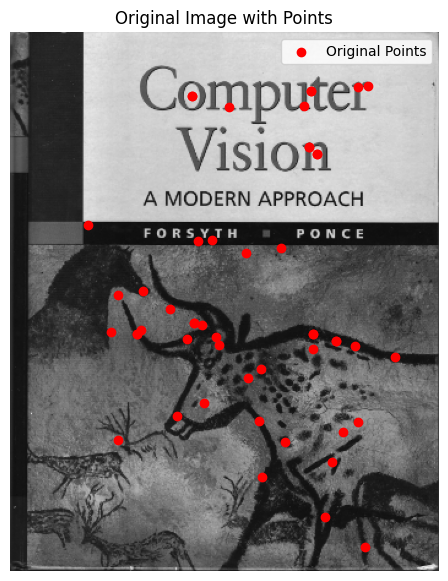

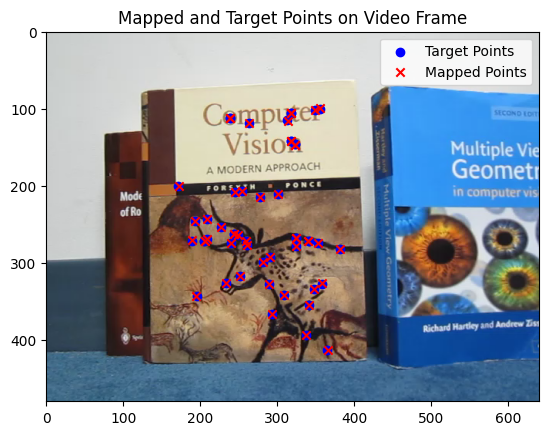

In [6]:
def verify_homography(H, original_points, target_points, image1, image2):
    mapped_points = []
    for point in original_points:
        # Convert to homogeneous coordinates
        hom_point = np.matrix([point[0], point[1], 1]).T
        # Map using the homography matrix
        mapped_point = np.array(np.dot(H, hom_point)).T[0]

        # Normalize to heterogenous coordinates
        mapped_point /= mapped_point[2]
        mapped_points.append((mapped_point[0], mapped_point[1]))

    # Convert to numpy array
    mapped_points = np.array(mapped_points)

    plt.figure(figsize=(15, 7))
    
    plt.imshow(image1)
    plt.scatter(original_points[:, 0], original_points[:, 1], color='red', label='Original Points')
    plt.title("Original Image with Points")
    plt.axis("off")
    plt.legend()
    plt.show()
    plt.imshow(image2)
    plt.scatter(target_points[:, 0], target_points[:, 1], color='blue', label='Target Points')
    plt.scatter(mapped_points[:, 0], mapped_points[:, 1], color='red', label='Mapped Points', marker='x')
    plt.title("Mapped and Target Points on Video Frame")
    plt.legend()

    plt.show()

original_points = np.array([kp1[m.queryIdx].pt for m in good_matches])
target_points = np.array([kp2[m.trainIdx].pt for m in good_matches])

# Call it to verify the homography visually
book_img_rgb = cv2.cvtColor(book_img, cv2.COLOR_BGR2RGB)
verify_homography(H, original_points, target_points, book_img_rgb, firstframe)

Mapping book corners into tge first video frame

Book Dimensions: 440x350, Aspect Ratio: 0.7954545454545454


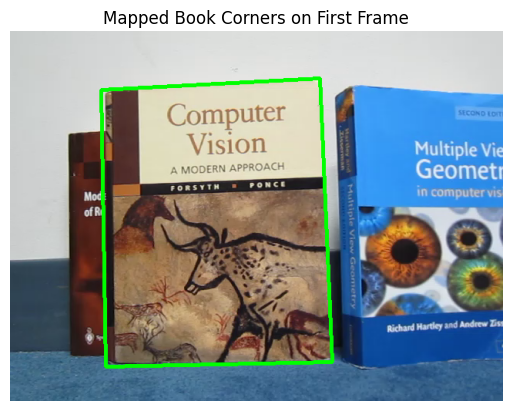

In [7]:

h_book, w_book = book_img.shape[:2]
book_corners = np.float32([[0, 0], [w_book, 0], [w_book, h_book], [0, h_book]]).reshape(-1, 1, 2)
book_aspect =  w_book / h_book
print(f"Book Dimensions: {h_book}x{ w_book}, Aspect Ratio: {book_aspect}")
# Warp corners using homography
mapped_corners = cv2.perspectiveTransform(book_corners, H)  # Used instead of np.dot(H, book_corners) to process all points at once and normalization

# Draw on first frame
overlay = firstframe.copy()
cv2.polylines(overlay, [np.int32(mapped_corners)], True, (0, 255, 0), 3)
plt.imshow(overlay)
plt.axis('off')         
plt.title("Mapped Book Corners on First Frame")
plt.show()

Crop AR Video Frames to Match Book Aspect Ratio

AR Video Dimensions: 640x360, Aspect Ratio: 1.7777777777777777
Cropping Rectangle: (177, 0, 286, 360)
Processed 511 frames.
(440, 350, 3)


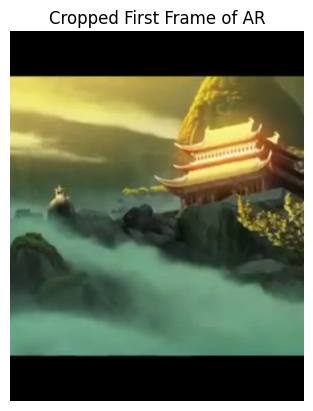

Cropped video saved to D:\MERNA\CV_assignments\cropped_video.mp4.


In [ ]:
#Load the AR source video
ar_video = cv2.VideoCapture(movie_video)

#Get video properties(dimensions & fps)
ar_width = int(ar_video.get(cv2.CAP_PROP_FRAME_WIDTH))
ar_height = int(ar_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
ar_fps = int(ar_video.get(cv2.CAP_PROP_FPS))
ar_aspect = ar_width / ar_height
print(f"AR Video Dimensions: {ar_width}x{ar_height}, Aspect Ratio: {ar_aspect}")

#Initialize video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video_writer = cv2.VideoWriter( cropped_video, fourcc, ar_fps, (w_book, h_book))


#Calculate cropping region
if ar_aspect > book_aspect:
    #AR video is wider than the book, crop horizontally
    new_width = int(book_aspect * ar_height)
    x_start = (ar_width - new_width) // 2
    crop_window = (x_start, 0, new_width, ar_height)
else:
    #AR video is taller than the book, crop vertically
    new_height = int(ar_width / book_aspect)
    y_start = (ar_height - new_height) // 2
    crop_window = (0, y_start, ar_width, new_height)

print(f"Cropping Rectangle: {crop_window}")


#Process AR video frames
cropped_frames = []
while True:
    ret, frame = ar_video.read()
    if not ret:
        break  # End of video

    #Crop the frame to match the book's aspect ratio
    x, y, w, h = crop_window
    c_frame = frame[y:y+h, x:x+w]

    #Resize cropped frame to match book dimensions
    resized_frame = cv2.resize(c_frame, ( w_book, h_book))


    #Write the resized frame to the output video
    video_writer.write(resized_frame)

    #Store resized frames
    cropped_frames.append(resized_frame)

print(f"Processed {len(cropped_frames)} frames.")
arfirstframe_cropped= cv2.cvtColor(cropped_frames[0] , cv2.COLOR_BGR2RGB)

plt.imshow(arfirstframe_cropped)
plt.axis('off')
plt.title("Cropped First Frame of AR")
plt.show()
#Release resources
ar_video.release()
video_writer.release()

print(f"Cropped video saved to {cropped_video}.")

Overlay First AR Frame on First Book Frame

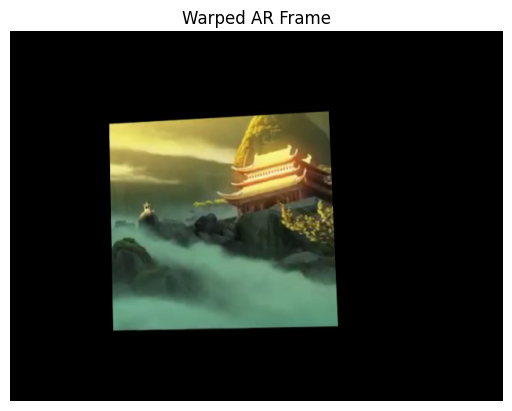

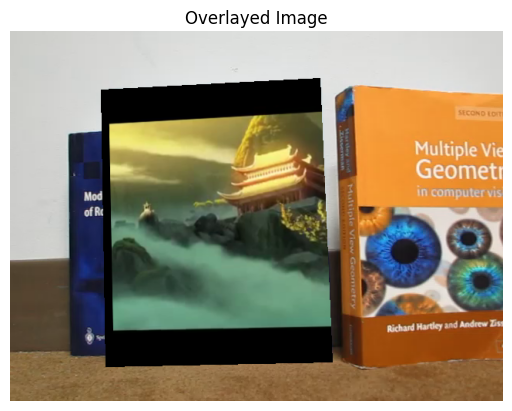

In [24]:
# Warp AR frame onto book location
warped_ar = cv2.warpPerspective(arfirstframe_cropped, H, (firstframe.shape[1], firstframe.shape[0]))
plt.imshow(warped_ar)
plt.axis('off')
plt.title("Warped AR Frame")
plt.show()

# Create mask and blend
mask = np.zeros((firstframe.shape[0], firstframe.shape[1], 3), dtype=np.uint8)  # Ensure mask has 3 channels
cv2.fillPoly(mask, [np.int32(mapped_corners)], (255, 255, 255))  # Use mapped_corners for the polygon
mask_inv = cv2.bitwise_not(mask)

# Ensure all images have the same size and number of channels
firstframe_rgb = cv2.cvtColor(firstframe, cv2.COLOR_BGR2RGB)  # Convert firstframe to RGB
background = cv2.bitwise_and(firstframe_rgb, mask_inv)
foreground = cv2.bitwise_and(warped_ar, mask)
combined = cv2.add(background, foreground)

plt.imshow(combined)
plt.axis('off') 
plt.title("Overlayed Image")
plt.show()

Full AR Video Generation

In [37]:
# Initialize video writer for output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')        

book_video= cv2.VideoCapture(book_vid_path)
frame_width = int(book_video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(book_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
book_fps = int(book_video.get(cv2.CAP_PROP_FPS))
frames_lengths = int(book_video.get(cv2.CAP_PROP_FRAME_COUNT))
video_writer = cv2.VideoWriter(output_video,fourcc,book_fps,(frame_width, frame_height))

idx = -1
#Read the book video frame by frame
while True:
    ret, frame = book_video.read()
    if not ret:
        print("End of book video.")
        break  # End of video

    frame= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(frame, None)

    # Match descriptors with BFMatcher and KNN
    matches = bf.knnMatch(des1, des, k=2)
    # Apply Lowe's ratio test  
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    # print(f"Number of good matches: {len(good_matches)}")
    # PICK 50 random matches
    good_matches = sorted(good_matches,key=lambda x: x.distance)[:50]
    # print(f"Good matches after sorting: {good_matches}")
    #  Homography
    if len(good_matches) >= 10:
        # Extract location of good matches
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
        dst_pts = np.float32([kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
        # Compute homography
        H = find_Homography(src_pts, dst_pts)
        idx+=1
        if H is None:
            print("Homography could not be computed.")
            continue  # Skip this frame
        elif np.linalg.det(H) < 0.1:
            # print("Unstable homography. Skipping frame.")
            continue
        else:
            ar_frame = cropped_frames[idx % len(cropped_frames)]
            # Warp AR frame onto book location
            warped_ar = cv2.warpPerspective(ar_frame, H, (frame_width, frame_height))


            corners = np.float32([[0, 0],
                                [ar_frame.shape[1], 0],
                                [ar_frame.shape[1], ar_frame.shape[0]],
                                [0, ar_frame.shape[0]]]).reshape(-1, 1, 2)
            warped_corners = cv2.perspectiveTransform(corners, H)

            # Blend the images
            mask = np.zeros((frame.shape[0], frame.shape[1]), dtype=np.uint8)  # Single-channel mask
            cv2.fillConvexPoly(mask, np.int32(warped_corners), 255)  # Fill with white
            mask_inv = cv2.bitwise_not(mask)
            
            # Convert masks to 3 channels to match fframe and warped_ar
            mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
            mask_inv = cv2.cvtColor(mask_inv, cv2.COLOR_GRAY2BGR)
            
            fframe = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)  # Convert grayscale frame to BGR for compatibility
            background = cv2.bitwise_and(fframe, mask_inv)
            foreground = cv2.bitwise_and(warped_ar, mask)
            combined = cv2.add(background, foreground)

            video_writer.write(combined)
            if idx % 50 == 0:
                print(f"Processed frame {idx} of {frames_lengths}")
               
    else:
            video_writer.write(cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR))  
               
# Release resources
print(idx)   
book_video.release()
video_writer.release()           

Processed frame 0 of 641
Processed frame 50 of 641
Processed frame 100 of 641
Processed frame 150 of 641
Processed frame 200 of 641
Processed frame 250 of 641
Processed frame 300 of 641
Processed frame 350 of 641
Processed frame 400 of 641
Processed frame 450 of 641
Processed frame 500 of 641
Processed frame 550 of 641
Processed frame 600 of 641
End of book video.
640
